In [ ]:
# TODO:
# Add PCA spectrum [1,2,4,...,n] dimensions, one curve each
# Add Scale-space spectrum (blur/decimate by 2 or sqrt(2)), one curve each
# 3D curve plot?

import lzma
import zlib
import gzip

def compress_lzma_len(s):
    filters = [
        {"id": lzma.FILTER_DELTA, "dist": 5},
        {"id": lzma.FILTER_LZMA2, "preset": 7 | lzma.PRESET_EXTREME},
    ]
    return len(lzma.compress(s, format=lzma.FORMAT_RAW, filters=filters))

def compress_zlib_len(s):
    return len(zlib.compress(s, wbits=-15, level=9))

def ncd(a, b):
    # compute the normalised compression distance between a and b
    z_ab = compress_len(a+b)
    z_a = compress_len(a)
    z_b = compress_len(b)
    return (z_ab - min(z_a, z_b)) / max(z_a, z_b)

def encode_sequence(ls):
    """Encode a sequence of integers as a byte string. 
    If all integers are in the range 0-255, each is encoded as a byte;
    if in range 0-65535 as byte pairs, in the platform endianness."""
    
    if len(ls)==0 or max(ls)<255:
        s = [int(l).to_bytes(1) for l in ls]
    else:
        s = [int(l).to_bytes(2) for l in ls]
    return b''.join(s)

def compress_len(ls, mode="zlib"):
    """Return the compressed length of ls.
    Mode can be either "zlib" or "lzma"
    """
    s = encode_sequence(ls)
    if mode=="zlib":
        return compress_zlib_len(s)
    elif mode=="lzma":
        return compress_lzma_len(s)

def r_compress_len(ls, mode="zlib"):
    """Return a compression ratio from 0.0 to 1.0, 
    from a sequence of integers ls, accounting for
    the compression of an empty sequence (e.g. header data)
    mode can be "zlib" or "lzma"
    """    
    return len(ls) / ((compress_len(ls, mode) ) - (compress_len([], mode))) 

In [111]:
from scipy.ndimage import gaussian_filter1d

def gaussian_pyramid(signal, factor=2, min_length=1):
    """Take a MxN signal, and progressively blur
    and decimate the signal until it becomes [min_length x N].
    Return each level of the pyramid, from full resolution to min_length.
        len(signal)xN
        len(signal)/2 x N
        len(signal)/4 x N
        ...
        1 x N
        (assuming factor=2 and min_length=1)
    """
    pyramid_levels = [signal]
    std_dev = np.sqrt(factor**2 - 1)  # Calculate standard deviation for Gaussian filter
    while len(pyramid_levels[-1])>min_length:        
        smoothed_signal = gaussian_filter1d(pyramid_levels[-1], std_dev, axis=0)
        downsampled_signal = smoothed_signal[::factor]
        pyramid_levels.append(downsampled_signal)
    return pyramid_levels
    

def pca_range(n):
    """Generate a sequence of integers decreasing by a factor of 2,
    but always include 1 and 2 if n>1."""
    r = [n]
    while n>1:        
        if n>3:
            n = n // 2
        else:
            n = n - 1
        r.append(n)
    return r

print([pca_range(k) for k in range(1,100_000,1000)])


[[1], [1001, 500, 250, 125, 62, 31, 15, 7, 3, 2, 1], [2001, 1000, 500, 250, 125, 62, 31, 15, 7, 3, 2, 1], [3001, 1500, 750, 375, 187, 93, 46, 23, 11, 5, 2, 1], [4001, 2000, 1000, 500, 250, 125, 62, 31, 15, 7, 3, 2, 1], [5001, 2500, 1250, 625, 312, 156, 78, 39, 19, 9, 4, 2, 1], [6001, 3000, 1500, 750, 375, 187, 93, 46, 23, 11, 5, 2, 1], [7001, 3500, 1750, 875, 437, 218, 109, 54, 27, 13, 6, 3, 2, 1], [8001, 4000, 2000, 1000, 500, 250, 125, 62, 31, 15, 7, 3, 2, 1], [9001, 4500, 2250, 1125, 562, 281, 140, 70, 35, 17, 8, 4, 2, 1], [10001, 5000, 2500, 1250, 625, 312, 156, 78, 39, 19, 9, 4, 2, 1], [11001, 5500, 2750, 1375, 687, 343, 171, 85, 42, 21, 10, 5, 2, 1], [12001, 6000, 3000, 1500, 750, 375, 187, 93, 46, 23, 11, 5, 2, 1], [13001, 6500, 3250, 1625, 812, 406, 203, 101, 50, 25, 12, 6, 3, 2, 1], [14001, 7000, 3500, 1750, 875, 437, 218, 109, 54, 27, 13, 6, 3, 2, 1], [15001, 7500, 3750, 1875, 937, 468, 234, 117, 58, 29, 14, 7, 3, 2, 1], [16001, 8000, 4000, 2000, 1000, 500, 250, 125, 62, 31, 

In [92]:
r_compress_len([1,2,3,4,5,1,2,3,4,5])

1.4285714285714286

In [75]:
import numpy as np
import scipy.cluster
import matplotlib.pyplot as plt
import sklearn.decomposition, sklearn.preprocessing

def vq(m, k, whiten="standard", pca=None):
    """Given a MxN matrix m representing a signal with N attributes
    and an integer k, vector quantize m, and return
    M cluster indices and the average distortion 
    (i.e. average distance to cluster centroids over the whole dataset)
    whiten can be: "standard", "sphere" (i.e. covariance), "minmax", or "none"
    if `pca` is not None, then PCA is performed and `pca` dimensions are kept before VQ
    """
    if whiten=="standard":        
        m_white = sklearn.preprocessing.StandardScaler().fit_transform(m)
    elif whiten=="sphere":
        # PCA with no reduction
        m_white = sklearn.decomposition.PCA(n_components=m.shape[1], whiten=True).fit_transform(m)
    elif whiten=="minmax":
        m_white = sklearn.preprocess.MinMaxScaler().fit_transform(m)
    elif whiten == "none":
        m_white = m
    # allow PCA reduction if requested
    if pca is not None:
        m_white = sklearn.decomposition.PCA(m_white, n_components=pca, whiten=True).fit_transform(m)
    code, distortion = scipy.cluster.vq.kmeans(m_white, k)
    codes, dists = scipy.cluster.vq.vq(m_white, code)
    return codes, np.mean(dists)

In [76]:
def vq_range(m, ks, **kwargs):
    # Vector quantize m with each of k clusters from ks
    # return the vector quantised version and the avg. distortion
    all_codes = []
    all_dists = []
    for k in ks:
        codes, dists = vq(m, k, **kwargs)
        all_dists.append(dists)
        all_codes.append(codes)
    return all_codes, all_dists

In [77]:
def compression_curve(m, ks, n_surrogates = 5, **kwargs):
    # compress m with VQ clusters from the sequence ks
    # return all the ratios and all the average distortion levels
    all_codes, all_dists = vq_range(m, ks, **kwargs)
    z_curve = [r_compress_len(code_seq) for code_seq in all_codes]
    z_surrogate = np.mean([[r_compress_len(np.random.permutation(code_seq)) for code_seq in all_codes] for i in range(n_surrogates)], axis=0)
    return z_curve, z_surrogate, all_dists


In [78]:
gauss_z_curve = [0.169, 0.2516, 0.3124, 0.3592, 0.3957, 0.4278, 0.4537, 0.4772, 0.4943, 0.5057, 0.5216, 0.5352, 0.5472, 0.5586, 0.5683, 0.576, 0.5859, 0.5916, 0.5999, 0.6096, 0.6194, 0.625, 0.6346, 0.6406, 0.6555, 0.6649, 0.675, 0.6897, 0.6995, 0.7097, 0.7289, 0.7429, 0.7548, 0.7683, 0.7777, 0.7924, 0.809, 0.8191, 0.8329, 0.8454, 0.8579, 0.8719, 0.883, 0.8988, 0.9157, 0.9286, 0.9416, 0.9554, 0.9721, 0.9839, 0.9975]

In [79]:
from matplotlib.ticker import ScalarFormatter, NullFormatter
def plot_compression_curve(ax, ks, z, z_surrogate, d, z_c='C0', d_c='C1'):
    ax.set_xlabel("VQ vectors (log scale)")
    ax.set_ylabel("Adjusted compression ratio")
    # we always compress bytes, so compute
    # the "fraction of a byte" with this many symbols    
    k_bits = np.log2(np.array(ks))
    max_inf = 8.0/k_bits
    # adj_max_inf = (0.11297548 * (np.log2(ks) + 0.8978397))
    # adjust for the number of symbols
    adj_ratio = np.array(z)  / z_surrogate
    ax.semilogx(ks, adj_ratio, c=z_c, base=2)
    ax.semilogx(ks, adj_ratio, c=z_c, base=2, marker='+')
    
    ax.fill_between(ks, 1.0, adj_ratio, color=z_c, alpha=0.2)
    ax.set_ylim(0.5,5)
    # expect compression = 1.0 for random data
    ax.axhline(1.0, ls=':', c=z_c)
    ax2 = ax.twinx()
    ax2.set_ylabel("Relative VQ distortion (dB)")
    # expected quantisation noise = 6.02 * quantisation_bits
    exp_dist = 6.02 * k_bits - 1.76
    # expect relative distortion = 0.0 for random quantisation noise
    ax2.axhline(0.0, ls=':', c=d_c)
    ax2.semilogx(ks, 20.0*np.log10(d)+exp_dist, c=d_c, alpha=0.5, base=2, subs=np.linspace(1,2,9))        
    ax2.set_ylim(-10, 10)    
    ax.set_xlim(2, 260)
    for axis in [ax.xaxis]:
        axis.set_major_formatter(ScalarFormatter())
        axis.set_minor_formatter(NullFormatter())

In [80]:
    

k_range = np.unique((2.0 ** np.linspace(1,7.99,65)).astype(np.int64))

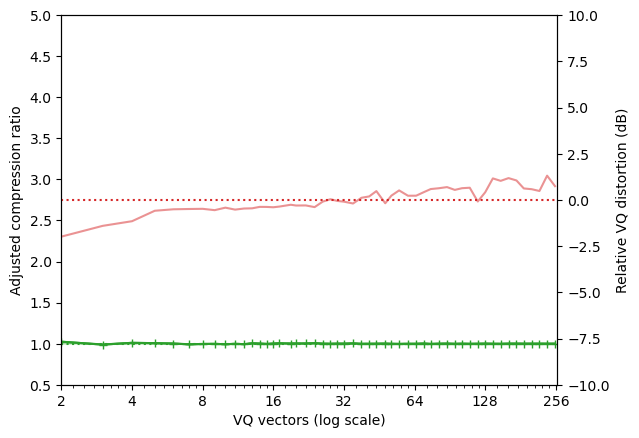

In [81]:
fig, ax = plt.subplots()

test_m = np.random.normal(0,1,(1500,1))
z_curve, z_surrogate, d_curve = compression_curve(test_m, k_range, whiten="standard")
plot_compression_curve(ax, k_range, z_curve, z_surrogate, d_curve, 'C2', 'C3')


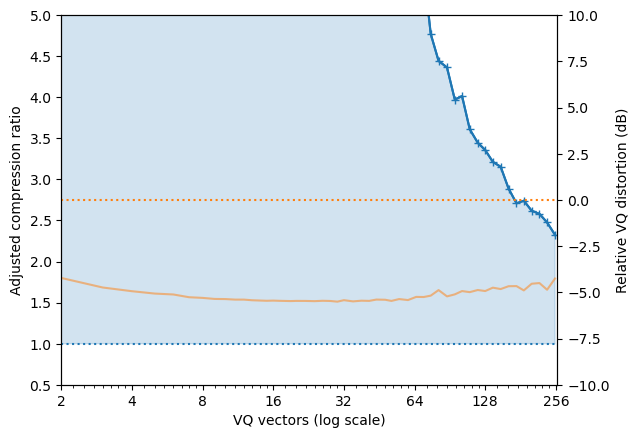

In [85]:
fig, ax = plt.subplots()
xs = np.linspace(0,40,4000)
test_m = (np.sin(xs))[:,None]
z_curve, z_surrogate, d_curve = compression_curve(test_m, k_range, whiten="sphere")
plot_compression_curve(ax, k_range, z_curve, z_surrogate, d_curve)

In [83]:
import scipy.io
sr, ex7 = scipy.io.wavfile.read("ex7.wav")
ex7 = ex7 / 65535.0


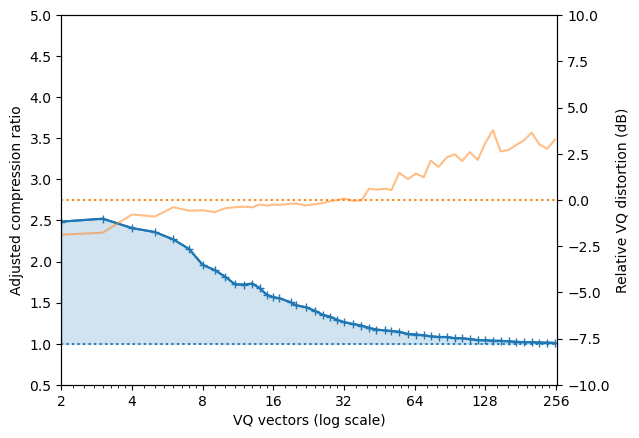

In [84]:
fig, ax = plt.subplots()
ex7_decimated = ex7[:45000:8, None]
z_curve, z_surrogate, d_curve = compression_curve(ex7_decimated, k_range, whiten="sphere")
plot_compression_curve(ax, k_range, z_curve, z_surrogate, d_curve)

C:\Users\John\AppData\Local\Temp\ipykernel_6376\1070692575.py:6: RuntimeWarning: divide by zero encountered in divide
  ax.plot(ks, np.array(z)/max_inf, c=z_c)


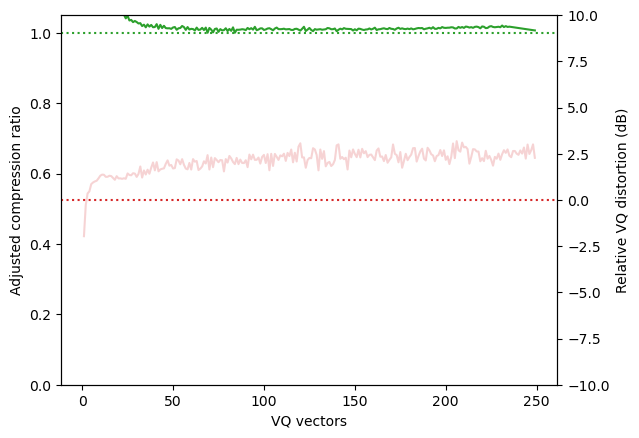

In [270]:
fig, ax = plt.subplots()
k_range = range(1,250,1)    
test_m = np.random.normal(0,1,(2000,1))
z_curve, d_curve = compression_curve(test_m, k_range)
plot_compression_curve(ax, k_range, z_curve, d_curve, 'C2', 'C3')

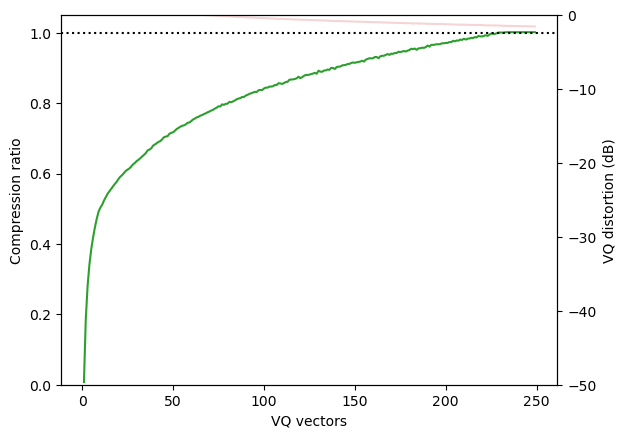

In [220]:
fig, ax = plt.subplots()
k_range = range(1,250,1)    
test_m = np.random.normal(0,1,(2000,5))
z_curve, d_curve = compression_curve(test_m, k_range)
plot_compression_curve(ax, k_range, z_curve, d_curve, 'C2', 'C3')